In [43]:
import yfinance as yf
import pandas as pd
import pandas_ta
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [44]:
snp500 = yf.Ticker("spy").history(period="max") # all data for the GSPC index fund since 1927
snp500.columns = snp500.columns.str.lower()

<AxesSubplot:xlabel='Date'>

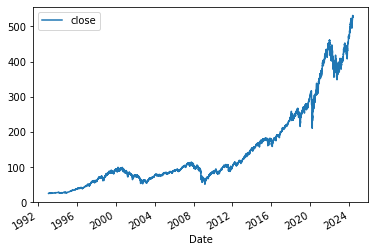

In [45]:
del snp500["dividends"] # get rid of stock splits and dividends since this is an index fund
del snp500["stock splits"]

snp500["tomorrow"] = snp500["close"].shift(-1) # make a column representing the closing price for the next day
snp500["target"] = (snp500["tomorrow"] > snp500["close"]).astype(int) # make a column for the direction of the stock (up or down)
# "target" will be our y value

snp500 = snp500.loc["1990-01-02":].copy() # only considering data from 1990 onwards
snp500.plot.line(y="close", use_index=True)

In [46]:
# ignore all this; I checked other metrics and technical indicators but none of them really work
# snp500['garman_klass_vol'] = (((np.log(snp500['high'])-np.log(snp500['low']))**2)/
#                               2-(2*np.log(2)-1)*((np.log(snp500['close'])-np.log(snp500['open']))**2))

# snp500['rsi'] = pandas_ta.rsi(snp500["close"], length=20)

# snp500["bbands_low"] = pandas_ta.bbands(snp500["close"], length=20).iloc[:, 0]

# snp500["bbands_mid"] = pandas_ta.bbands(snp500["close"], length=20).iloc[:, 1]

# snp500["bbands_high"] = pandas_ta.bbands(snp500["close"], length=20).iloc[:, 2]

# snp500["atr"] = pandas_ta.atr(high=snp500['high'],
#                         low=snp500['low'],
#                         close=snp500['close'],
#                         length=14)
# snp500['dollar_volume'] = (snp500['close']*snp500['volume'])/1e6

# snp500 = snp500.dropna().copy()

In [47]:
# adding close ratios and trends columns for 2, 5, 10, 30, 60, 250, and 1000 trading days
# these will be our predictors
horizons = [2, 5, 10, 30, 60, 250, 1000]
predictors = []

def calculate_ratios_trends(data):
    p = []
    for horizon in horizons:
        rolling_averages = data.rolling(horizon).mean()

        ratio_column = f"close_ratio_{horizon}"
        data[ratio_column] = data["close"] / rolling_averages["close"]

        trend_column = f"trend_{horizon}"
        data[trend_column] = data.shift(1).rolling(horizon).sum()["target"]
        p += [ratio_column, trend_column]
        
    return (data, p)

snp500 = calculate_ratios_trends(snp500)[0].copy()
predictors = calculate_ratios_trends(snp500)[1]
snp500_last_row = snp500.iloc[[-1]]
snp500 = snp500.dropna()

In [48]:
length_snp = len(snp500)
train_test_split = 0.8 # 80% of the data will be used to train

snp500_train = snp500.iloc[0:int(length_snp * train_test_split)].copy()  
snp500_test = snp500.iloc[int(length_snp * train_test_split):].copy()  

# snp500_train = snp500.iloc[:-14].copy() 
# snp500_test = snp500.iloc[-14:].copy()

# scaler = StandardScaler()
# snp500_train_scaled = scaler.fit_transform(snp500_train[predictors])
# snp500_test_scaled = scaler.fit_transform(snp500_test[predictors])

In [49]:
rfc_model = RandomForestClassifier(n_estimators=300, min_samples_split=2, min_samples_leaf=2, 
                               max_depth=10, max_features="auto", random_state=42) # rfc model
rfc_model.fit(snp500_train[predictors], snp500_train["target"])
# best parameters: 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300


RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

In [50]:
# generate predictions 
def generate_predictions(model, data, predictors, threshold=0.5):

    predictions = model.predict_proba(data[predictors])[:, 1] # this will give us a probability, not a 1 or a 0
    
    predictions[predictions >= threshold] = 1 # set the threshold; if the probablity is over the threshold, only then we will count it
    predictions[predictions < threshold] = 0

    predictions = pd.Series(predictions, index=data.index, name="predictions")

    p_score = precision_score(data["target"], predictions) # precision score, true positives divided by true + false positives
    print(f"Precision score for the split: {p_score}")
    
    print("Total buy days %: ", predictions.sum() * 100 / len(predictions), "%") # percentage of days the model recommends to buy
    
    return predictions


In [51]:
training_set_predictions = generate_predictions(rfc_model, snp500_train, predictors) # training predictions (will be higher)
testing_set_predictions = generate_predictions(rfc_model, snp500_test, predictors) # testing predictions 


Precision score for the split: 0.6897682041676423
Total buy days %:  77.51361161524501 %
Precision score for the split: 0.5611164581328201
Total buy days %:  75.39912917271408 %


In [52]:
# this will simulate you buying and selling based on the model alone
# this will simulate you buying everyday and selling everyday, regardless of what the model says
# model will be the random forest classifier, start and end date are self explanatory, starting_total will be the 
# amount of money you start with, percentage_traded_per_day will be the percentage of money traded everyday, and
# predictors will be the the predictors we came up with earlier.
def simulate_paper_trading(model, start_date, end_date, starting_total, 
                           percentage_traded_per_day, predictors, dataset=None):
    total = starting_total
    start_date_int, end_date_int = "", ""
    
    if dataset is None:
        try:
            start_date_int = snp500.index.get_loc(start_date) 
        except Exception as e:
            print("Start date is a non-trading day. Please enter a valid trading day.")
            return
        try:
            end_date_int = snp500.index.get_loc(end_date)   
        except Exception as e:
            print("Start date is a non-trading day. Please enter a valid trading day.")
            return
    
    # if you provide the dataset, ignore the start and end date
    dataset = snp500.iloc[start_date_int:end_date_int + 1].copy() if dataset is None else dataset
    predictions = generate_predictions(model, dataset, predictors)
    
    for i in range(len(predictions)):
        current_stock_price = dataset.iloc[i]["close"]
        if predictions[i] == 1:
            day_profit = ((dataset.iloc[i]["tomorrow"] - dataset.iloc[i]["close"]) 
                          * ((percentage_traded_per_day * total) / current_stock_price))
            total += day_profit
            
            
    print(f"Total amount after trading via algorithm: {total}")
    
    total = starting_total
    
    for i in range(len(predictions)):
        current_stock_price = dataset.iloc[i]["close"]
        day_profit = ((dataset.iloc[i]["tomorrow"] - dataset.iloc[i]["close"]) 
                      * ((percentage_traded_per_day * total) / current_stock_price))
        total += day_profit
        
    print(f"Total amount from buying and selling everyday without pattern: {total}")

In [53]:
start_date = "2022-05-03" # ignore if the dataset is already provided
end_date = "2024-05-01" # ignore if the dataset is already provided
starting_total = 10000
percentage_traded_per_day = 1 # fraction of your total you trade with; stick with 1 since we always give 100% into everything we do, even gambling
simulate_paper_trading(rfc_model, start_date, end_date, starting_total, 
                       percentage_traded_per_day, predictors, dataset=snp500_test)


Precision score for the split: 0.5611164581328201
Total buy days %:  75.39912917271408 %
Total amount after trading via algorithm: 32262.57179302729
Total amount from buying and selling everyday without pattern: 21316.60284741192


In [54]:
def predict_next_day():
    data = pd.concat([snp500_train, snp500_test], axis=0)
    rfc_model.fit(data[predictors], data["target"])
    prediction = rfc_model.predict_proba(snp500_last_row[predictors])[:, 1]
    return prediction

predict_next_day()

array([0.56290605])

In [55]:
snp500_last_row

,open,high,low,close,volume,capital gains,tomorrow,target,close_ratio_2,trend_2,...,close_ratio_10,trend_10,close_ratio_30,trend_30,close_ratio_60,trend_60,close_ratio_250,trend_250,close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-29 00:00:00-04:00,525.679993,527.304993,525.369995,526.179993,38182920,0.0,NaN,0,0.996562,1.0,...,0.994564,6.0,1.02018,19.0,1.020688,32.0,1.128544,142.0,1.293949,537.0
